University of Helsinki, Master's Programme in Data Science  
DATA20019 Trustworthy Machine Learning, Autumn 2021  
Antti Honkela and Ossi Räisä  

# Project 2: Real-life privacy-preserving machine learning

Deadline for returning the solutions: 28 November 23:55.

## General instructions (IMPORTANT!)

1. This is an individual project. You can discuss the solutions with other students, but everyone needs to write their own code and answers.
2. Please return your solutions as a notebook. When returning your solutions, please leave all output in the notebook.
3. When returning your solutions, please make sure the notebook can be run cleanly using "Cell" / "Run All".
4. Please make sure there are no dependencies between solutions to different problems.
5. Please make sure that your notebook will not depend on any local files.
6. Please make sure that the solutions for each problem in your notebook will produce the same results when run multiple times, i.e. remember to seed any random number generators you use (`numpy.random.seed()`, `torch.manual_seed()`!).


## Task 1: Differentially private logistic regression with DP-SGD

The Opacus (https://opacus.ai/) library provides implementations of many differentially private optimisation algorithms for deep learning and other models for the PyTorch (https://pytorch.org/) library. In order to perform these exercises, you will need to install Opacus, PyTorch and their dependencies according to instructions given on the websites. If you have not used PyTorch before, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html is a good tutorial on the basics.

In order to study Opacus, we will use logistic regression on the UCI Adult data set (https://archive.ics.uci.edu/ml/datasets/Adult). (The data set is a standard benchmark data set that is available in various packages - feel free to use one of those.)  

A simple example implementation of the model is available at (https://www.cs.helsinki.fi/u/oraisa/tml/dp_log_reg_opacus.py).
The code has been adapted from tutorials provided with Opacus.

The definition of the logistic regression model binary classification is itself very straightforward in PyTorch, simply using a single fully connected linear layer with cross entropy loss:
```{python}
class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        # Define logistic regression using torch.nn layer and loss function
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")
```
Training with privacy is done using the `PrivacyEngine` class, which is simply attached to 
any supported PyTorch optimiser.
```{python}
privacy_engine = PrivacyEngine(
    model,
    sample_rate=sample_rate,
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
    noise_multiplier=noise_multiplier,
    max_grad_norm=clip_bound,
    secure_rng=False, # Should set to True for production use
)
# Fix randomness, will throw an error with secure_rng=True
privacy_engine._set_seed(random_seed) 
privacy_engine.attach(optimizer)
```
Data subsampling is done by accessing the data through a `DataLoader` object that is configured with an Opacus-specific batch sampler.
```{python}
train_loader = DataLoader(
    train_tensor,
    batch_sampler=UniformWithReplacementSampler(
        num_samples=len(train_tensor),
        sample_rate=sample_rate,
        # Should use a cryptographically secure PRNG in production
        generator=torch.Generator().manual_seed(random_seed), 
    ),
)
```
The `secure_rng` and `generator` parameters of `PrivacyEngine` and `UniformWithReplacementSampler` define the random number generators used for noise and minibatch sampling. In this exercise, we use the default RNGs of PyTorch, and manually seed them for reproducibility, but true DP guarantees require using a cryptographically secure RNG.

The `alphas` parameter of `PrivacyEngine` is related to Rényi differential privacy (RDP), which Opacus uses internally to compute privacy bounds. RDP is an alternative definition of DP, where privacy bounds are parameterised by an $(\alpha, \epsilon)$-pair. Opacus computes RDP bounds for the given $\alpha$ values, converts each RDP bound to an $(\epsilon, \delta)$-bound with $\delta$ given, and returns the smallest $\epsilon$, along with the corresponding $\alpha$.
This means that if the given list of $\alpha$ values does not contain the optimal $\alpha$, the returned $\epsilon$ values are too large. As a simple heuristic, if the returned $\alpha$ value is one of the bounds of the given list of $\alpha$ values, you should expand the list.

The rest of the example provides supporting architecture. The `generate_data` function generates a small test dataset, and `create_data_loaders` creates `DataLoader` objects for training and test data that can be passed to the `train` and `test` functions. Key parameters of the algorithm are defined at the end of the file and given as parameters to the `train` function. These include:
```{python}
# Learning rate for training
learning_rate = 0.05
# Ratio of the standard deviation to the clipping norm
noise_multiplier = 2
# Clipping norm
clip_bound = 1
# Batch size as a fraction of full data size
sample_rate = 0.03
# Number of epochs
num_epochs = 2
```

`learning_rate` is the initial learning rate for the SGD optimiser. Larger value means faster learning but can cause instability.  
`noise_multiplier` controls the amount of noise added in DP-SGD: higher value means more noise. The value is defined relative to the gradient clip bound.  
`clip_bound` is the maximum norm at which per-example gradients are clipped. Smaller values mean less noise with the same level of privacy, but too small values can bias the results and make learning impossible.  
`sample_rate` is the fraction of full data used for each minibatch, which impacts privacy via amplification from subsampling. While a smaller sample rate increases privacy for a single update, it also increases the number of updates in a single epoch, which reduces privacy. The latter effect tends to be stronger than the first, so increasing sample rate increases privacy, but having too few updates limits the amount of learning.  
`num_epochs` controls the length of training as a number of passes over the entire data.

i. Test how these parameters (clip bound, sample rate, noise multiplier, learning rate and number of epochs) affect the accuracy of the classifier and its privacy. (You can use the test dataset from `generate_test_data` or the Adult dataset.)

ii. How accurate classifier can you build to predict if an individual has an income of at most 50k with the Adult dataset, using DP with $\epsilon=1, \delta = 10^{-5}$? Report your accuracy on a separate test set not used in learning. (Opacus does not offer an easy way to set the parameters to get $\epsilon = 1$, so you must tweak the parameters such that $\epsilon \leq 1$. You can use the function `check_privacy` to evaluate the privacy level at given parameters without actually running the optimisation.)

Hint: the data set includes many categorical variables. In order to use these, you will need to use a one-hot encoding with $n-1$ variables used to denote $n$ values so that $k$th value is represented by value 1 in $k-1$st variable and zeros otherwise. You do not need to use all of the variables for DP training, as a large number of variables increases the noise DP-SGD has to add, while some of the variables may not be useful for the prediction task.

Note: as noted at the lecture, testing several hyperparameters and choosing the best has an impact on the privacy guarantees.

Note: Unlike what the name suggests, `UniformWithReplacementSampler` samples a minibatch by selecting each element independently with the probability `sample_rate`. This implies that different minibatches will be of different sizes. This form of sampling works well with add/remove neighbourhoods that are commonly used in DP deep learning.

### Answer

#### Question I

For this question I used the random data generated by `generate_random_data()` function. I tested $\epsilon$ and accuracy on different parameters:

- learning_rate = [0.01, 0.05, 0.1, 0.5]
- noise_multiplier = [1, 1.5, 2, 2.5]
- clip_bound = [0.5, 1, 1.5, 2]
- sample_rate = [0.01, 0.03, 0.1, 0.2]

Then, I created a plot for each hyperparameter, relating accuracy score and $\epsilon$ on the number of epochs.

##### Preparatory code

In [ ]:
import sys
!{sys.executable} -m pip install torch opacus catboost

In [10]:
import numpy as np
import torch
import torch.nn as nn
import opacus
from torch.utils.data import DataLoader, TensorDataset
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")
    
    def forward(self, x):
        return self.linear(x).view(-1)

    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        preds = out > 0
        corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

def train(model, train_loader, opt_func, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=sample_rate,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        secure_rng=False,
    )
    privacy_engine._set_seed(random_seed)
    privacy_engine.attach(optimizer)

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    return epsilon, alpha

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

def create_data_loaders(train_tensor, test_tensor, sample_rate, random_seed=4732842):
    train_loader = DataLoader(
        train_tensor,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_tensor),
            sample_rate=sample_rate,
            generator=torch.Generator().manual_seed(random_seed),
        ),
    )
    test_loader = DataLoader(test_tensor, 64)
    return train_loader, test_loader

def check_privacy(sample_rate, noise_multiplier, num_epochs, delta = 1e-5,
                  alphas = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200))):
    rdp = opacus.privacy_analysis.compute_rdp(sample_rate, noise_multiplier, int(1 / sample_rate) * num_epochs, alphas)
    epsilon, opt_order = opacus.privacy_analysis.get_privacy_spent(alphas, rdp, delta)
    return epsilon, opt_order

def generate_random_data():
    np.random.seed(4242)

    n_train = 2000
    n_test = 2000
    input_dim = 5

    N = n_train + n_test
    X0 = np.random.randn(N, input_dim)
    temp = X0 @ np.random.randn(input_dim, 1) + np.random.randn(N, 1)
    Y0 = np.round(1/(1+np.exp(-temp)))

    train_X = X0[0:n_train, :]
    test_X = X0[n_train:N, :]
    train_Y = Y0[0:n_train, 0]
    test_Y = Y0[n_train:N, 0]
    train_X = np.array(train_X, dtype=np.float32)
    test_X = np.array(test_X, dtype=np.float32)
    train_Y = np.array(train_Y, dtype=np.int32)
    test_Y = np.array(test_Y, dtype=np.int32)

    train_tensor = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y, dtype=torch.float32))
    test_tensor = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y, dtype=torch.float32))

    return train_tensor, test_tensor

##### Actual code

In [23]:
# EXECUTION
torch.manual_seed(472368)
np.random.seed(0)
train_tensor, test_tensor = generate_random_data()
input_dim = train_tensor[0][0].size(dim=0)

delta = 1e-5

# Stock values
learning_rate = 0.05
noise_multiplier = 2
clip_bound = 1
sample_rate = 0.03
num_epochs = 2

# Experiments
learning_rates = [0.01, 0.05, 0.1, 0.5]
noise_multipliers = [1, 1.5, 2, 2.5]
clip_bounds = [0.5, 1, 1.5, 2]
sample_rates = [0.01, 0.03, 0.1, 0.2]

2000

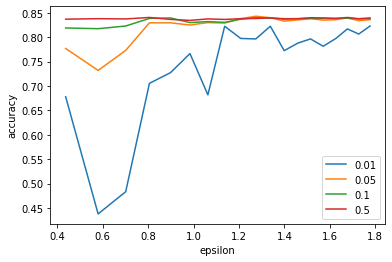

Best accuracy = 0.843 at epoch 10 
Best epsilon = 0.4370271431009314 at epoch 1


In [11]:
# Test learning rates
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for lr in learning_rates:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

    for epoch in range(1,20):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, lr, epoch, sample_rate,
            noise_multiplier, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
    plt.plot(x, y, label=lr)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

0.8305 3.425823765852539
0.83 1.606505346219157
0.83 1.0631997509804052
0.8275 0.7975639913311465


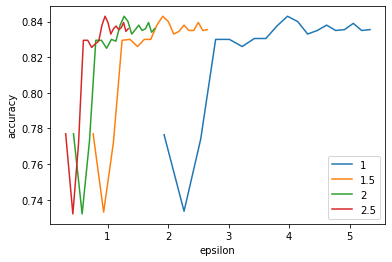

Best accuracy = 0.843 at epoch 10 
Best epsilon = 0.307764751385219 at epoch 1


In [12]:
# Test noise multiplier
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for nm in noise_multipliers:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

    for epoch in range(1,20):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, epoch, sample_rate,
            nm, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
        if epoch==7:
            print(total_accuracy, epsilon)
    plt.plot(x, y, label=nm)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

0.8055 0.8057752058544934
0.8295 0.8057752058544934
0.834 0.8057752058544934
0.8375 0.8057752058544934


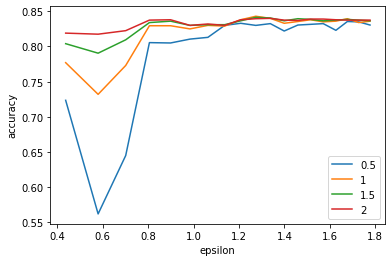

Best accuracy = 0.843 at epoch 10 
Best epsilon = 0.4370271431009314 at epoch 1


In [13]:
# Test clip bounds
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for cb in clip_bounds:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

    for epoch in range(1,20):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, epoch, sample_rate,
            noise_multiplier, cb, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
        if epoch==4:
            print(total_accuracy, epsilon)
    plt.plot(x, y, label=cb)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

0.8415 0.6107489046871944
0.829 1.1371093474900893
0.777 2.310840667143923
0.6145 3.4480118604326173


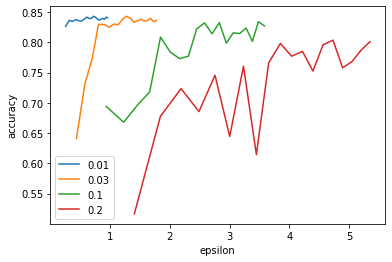

Best accuracy = 0.843 at epoch 10 
Best epsilon = 0.2571292377435178 at epoch 1


In [14]:
# Test sample rates
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for sr in sample_rates:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sr)

    for epoch in range(1,20):
        model = LogisticRegression(input_dim)
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, epoch, sr,
            noise_multiplier, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
        if epoch==8:
            print(total_accuracy, epsilon)
    plt.plot(x, y, label=sr)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

**Conclusions**

When changing learning rates, the first thing we can notice is that both $\epsilon$ and accuracy get higher with a higher number of epochs (so this is good from an accuracy perspective and bad from a privacy perspective). With learning rate equals to 0.5 both accuracy and $\epsilon$ are very good, but with such a high learning rate there's risk of overfitting. A good compromise could be learning rate equals to 0.1, since at epoch 4 accuracy is maximized (0.843) and the privacy is still good ($\epsilon$ equals to 0.8).

When changing noise multiplier, it is clear that more noise equals better privacy; it's surprising, though, that accuracy is still not that low even with more noise: a good compromise could be, in fact, noise multiplier equals to 2.6, when at epoch 7 accuracy is equal to 0.83 and $\epsilon$ is equal to 0.8.

When changing clip bounds, the results are similar to learning rates changing; a good compromise is at epoch 4 with clip bound equal to 2 (accuracy is equal to 0.84 and $\epsilon$ is equal to 0.81).

When changin the test sample rates, it is clear that wider test sample rates equal to less accuracy and less privacy. A good compromise is at epoch 8 with test sample rate equals to 0.01 ((accuracy is equal to 0.84 and $\epsilon$ is equal to 0.61).

#### Question II

Note: since, as said, a large number of variables increases the noise DP-SGD has to add, I decided to drop some of them; to be more specific, i dropped:

- `index`: there's already an index from pandas' dataframe
- `workclass`: some of the values are missing
- `education`: this column is redundant with `education-num`
- `marital-status`: this column is not fully redundant with `relationship` but they express quite the same meaning

Moreover, in order to use `income` as target I did not applied one-hot-encoding on it but I only changed the values in this way:

- 0 equals to `income` <=50K
- 1 equals to `income` >50K

##### Dataset preparation

In [24]:
import pandas as pd
from catboost.datasets import adult

# download Adult dataset and put all the data inside a single dataframe
train_set, test_set = adult()
data = train_set.append(test_set, ignore_index=False)
data = data.reset_index()

# prepare dataframe for usage
del data['index']
del data['workclass']
del data['education']
del data['marital-status']

# one-hot-encoding
occupation_ohe = pd.get_dummies(data.occupation, prefix='occupation')
relationship_ohe = pd.get_dummies(data.relationship, prefix='relationship')
race_ohe = pd.get_dummies(data.race, prefix='race')
sex_ohe = pd.get_dummies(data.sex, prefix='sex')
nativecountry_ohe = pd.get_dummies(data['native-country'], prefix='native_country')

# finish it
new = pd.concat([data, occupation_ohe, relationship_ohe, race_ohe, sex_ohe, nativecountry_ohe], axis=1)
data = new
del data['occupation']
del data['relationship']
del data['race']
del data['sex']
del data['native-country']
data['income'] = data['income'].apply(lambda x: 0 if x=='<=50K' else 1)
# now we have a dataframe, data, which contains all we need

##### Preparatory code

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import opacus
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
import warnings
warnings.filterwarnings('ignore')

def generate_tensors(train, test):
    train_X = train[train.columns.difference(['income'])]
    test_X = test[test.columns.difference(['income'])]
    train_Y = train['income']
    test_Y = test['income']

    train_X = torch.from_numpy(train_X.values)
    train_Y = torch.from_numpy(train_Y.values)
    test_X = torch.from_numpy(test_X.values)
    test_Y = torch.from_numpy(test_Y.values)

    train_tensor = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y, dtype=torch.float32))
    test_tensor = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y, dtype=torch.float32))
    return train_tensor, test_tensor

class LogisticRegression(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, 1, bias=bias)
        self.loss = nn.BCEWithLogitsLoss(reduction="sum")

    def forward(self, x):
        return self.linear(x.float()).view(-1)

    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        preds = out > 0 # Predict y = 1 if P(y = 1) > 0.5
        corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

def train(model, train_loader, opt_func, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=sample_rate,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        secure_rng=False, # Should set to True for production use
    )
    privacy_engine._set_seed(random_seed) # Fix randomness, will throw an error with secure_rng=True
    privacy_engine.attach(optimizer)

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    return epsilon, alpha

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

##### Actual code

In [65]:
train_set, test_set = train_test_split(data, test_size=0.2) # split into train and test
torch.manual_seed(472368)
train_tensor, test_tensor = generate_tensors(train_set, test_set)
input_dim = train_tensor[0][0].size(dim=0)

delta = 1e-5

learning_rate = 0.01
noise_multiplier = 2
clip_bound = 1
sample_rate = 0.02
num_epochs = 8
    
train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

model = LogisticRegression(input_dim)
epsilon, alpha = train(model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta)
print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epsilon: 0.9052277499557281, Delta: 1e-05, Alpha: 18.0
Loss: 0.3664154168319429, Accuracy: 0.7649708260825059


**Conclusions**

I was able to get a good accuracy score (0.76) with $\epsilon$ < 1 (0.91) and $\delta = 10^{-5}$ using the following hyperparameters:

- `learning_rate` = 0.01
- `noise_multiplier` = 2
- `clip_bound` = 1
- `sample_rate` = 0.02
- `num_epochs` = 8

## Task 2: DP Image Classification

Using the above code as a basis, build a DP image classifier for the MNIST dataset. The dataset consists of 28x28 images of handwritten digits (0-9), and the task is to classify which digit each image represents. 

A simple implementation of a convolutional neural network for image classification is available (https://www.cs.helsinki.fi/u/oraisa/tml/pytorch_mnist.py), based on the Opacus MNIST tutorial. The example requires the Torchvision (https://pytorch.org/vision/stable/index.html) library, which you should install. The example contains the `SampleConvNet` class that can be used with the `train` and `test` functions from the last exercise, as well as the `get_mnist_dataset` function that loads the MNIST dataset. The dataset is downloaded the first time the function is called and is placed in a directory called `mnist`. By default, the function only loads half of the training data (30 000 images) to save computation time, but the number of training images can be given as a parameter.

i. Train the model using the hyperparameters given below and compute accuracy on test data.
```{python}
clip_bound = 1.5
learning_rate = 0.25
sample_rate = 0.004
noise_multiplier = 1.3
num_epochs = 5
```
The training may take a minute or two. You can pass `verbose=True` to the `train` function to get updates for every completed epoch.
You should get $\epsilon \approx 0.62$ with $\delta = 10^{-5}$ and an accuracy of 80-90%.

ii. Test the impact of the different DP parameters with the aim of creating maximally accurate classifier, given privacy bounds $\epsilon = 1$, $\delta = 10^{-5}$. You can also try changing the optimiser.

Note: Running the learning with many parameters can take a long time, so you should plan your work to keep the number of runs reasonable. The grading of part ii is based on obtaining an overall picture of the impact of key parameters, not the absolute accuracy obtained.

### Answer

#### Question I

##### Preparatory code

In [ ]:
import sys
!{sys.executable} -m pip install torchvision

In [19]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2, 1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 1)
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        pred = out.argmax(dim=1, keepdim=True)
        corrects = pred.eq(y.view_as(pred)).sum().item()
        return loss, corrects
    
def get_mnist_dataset(train_size=30000):
    MNIST_MEAN = 0.1307
    MNIST_STD = 0.3081
    
    train_full_dataset = datasets.MNIST(
        "mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )
    train_subsample_loader = DataLoader(
        train_full_dataset, train_size,
        generator=torch.Generator().manual_seed(123456789)
    )
    train_subsample = train_subsample_loader.__iter__().__next__()
    train_dataset = TensorDataset(train_subsample[0], train_subsample[1])

    test_dataset = datasets.MNIST(
        "mnist",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )

    return train_dataset, test_dataset

def create_data_loaders(train_tensor, test_tensor, sample_rate, random_seed=4732842):
    train_loader = DataLoader(
        train_tensor,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_tensor),
            sample_rate=sample_rate,
            generator=torch.Generator().manual_seed(random_seed), # Should use a cryptographically secure PRNG in production
        ),
    )
    test_loader = DataLoader(test_tensor, 64)
    return train_loader, test_loader

def train(model, train_loader, opt_func, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=sample_rate,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        secure_rng=False,
    )
    privacy_engine._set_seed(random_seed)
    privacy_engine.attach(optimizer)

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    return epsilon, alpha

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy


##### Actual code

In [20]:
torch.manual_seed(54356)

train_tensor, test_tensor = get_mnist_dataset()
input_dim = train_tensor[0][0].size(dim=0)
delta = 1e-5

clip_bound = 1.5
learning_rate = 0.25
sample_rate = 0.004
noise_multiplier = 1.3
num_epochs = 5

train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

model = SampleConvNet()
epsilon, alpha = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
    noise_multiplier, clip_bound, delta
)
print("Epsilon: {}, Delta: {}, Alpha: {}".format(epsilon, delta, alpha))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epsilon: 0.6188836247099821, Delta: 1e-05, Alpha: 18.0
Loss: 5.521870255470276e-05, Accuracy: 0.8774


#### Question II

I tested $\epsilon$ and accuracy on different parameters:

- learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
- noise_multiplier = [1, 1.3, 1.5, 2, 2.5]
- clip_bound = [0.5, 1, 1.5, 2, 2.5]
- sample_rate = [0.04, 0.01, 0.05, 0.1, 0.2]

Then, I created a plot for each hyperparameter, relating accuracy score and $\epsilon$ on the number of epochs, with `epochs` between 1 and 10.

Finally, I tweaked the hyperparameter in order to get a higher accuracy with the same privacy assumptions.

##### Preparatory code

In [21]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2, 1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 1)
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        return loss

    def test_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.loss(out, y)
        pred = out.argmax(dim=1, keepdim=True)
        corrects = pred.eq(y.view_as(pred)).sum().item()
        return loss, corrects
    
def get_mnist_dataset(train_size=30000):
    MNIST_MEAN = 0.1307
    MNIST_STD = 0.3081
    
    train_full_dataset = datasets.MNIST(
        "mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )
    train_subsample_loader = DataLoader(
        train_full_dataset, train_size,
        generator=torch.Generator().manual_seed(123456789)
    )
    train_subsample = train_subsample_loader.__iter__().__next__()
    train_dataset = TensorDataset(train_subsample[0], train_subsample[1])

    test_dataset = datasets.MNIST(
        "mnist",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    )

    return train_dataset, test_dataset

def create_data_loaders(train_tensor, test_tensor, sample_rate, random_seed=4732842):
    train_loader = DataLoader(
        train_tensor,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_tensor),
            sample_rate=sample_rate,
            generator=torch.Generator().manual_seed(random_seed), # Should use a cryptographically secure PRNG in production
        ),
    )
    test_loader = DataLoader(test_tensor, 64)
    return train_loader, test_loader

def train(model, train_loader, opt_func, learning_rate, num_epochs, sample_rate, noise_multiplier, clip_bound, delta, random_seed=474237, verbose=False):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        model,
        sample_rate=sample_rate,
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 200)),
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        secure_rng=False,
    )
    privacy_engine._set_seed(random_seed)
    privacy_engine.attach(optimizer)

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    return epsilon, alpha

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

torch.manual_seed(54356)

train_tensor, test_tensor = get_mnist_dataset()
input_dim = train_tensor[0][0].size(dim=0)
delta = 1e-5

# stock hyperparameters
clip_bound = 1.5
learning_rate = 0.25
sample_rate = 0.004
noise_multiplier = 1.3
num_epochs = 5

# experiments
learning_rates = [0.01, 0.05, 0.1, 0.25, 0.5]
noise_multipliers = [1, 1.3, 1.5, 2, 2.5]
clip_bounds = [0.5, 1, 1.5, 2, 2.5]
sample_rates = [0.04, 0.01, 0.05, 0.1, 0.2]

##### Actual code

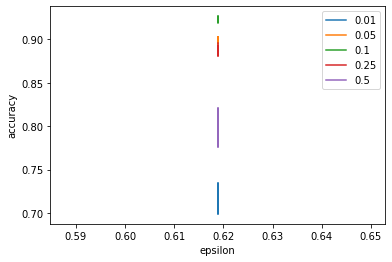

Best accuracy = 0.9267 at epoch 2 
Best epsilon = 0.6188836247099821 at epoch 9


In [23]:
# test learning rates
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for lr in learning_rates:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
    for epoch in range(1,10):
        model = SampleConvNet()
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, lr, num_epochs, sample_rate,
            noise_multiplier, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
    plt.plot(x, y, label=lr)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

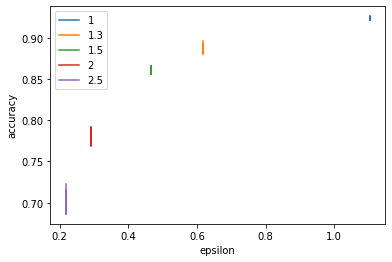

Best accuracy = 0.9261 at epoch 4 
Best epsilon = 0.21737942621110795 at epoch 9


In [24]:
# test noise multiplier
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for nm in noise_multipliers:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
    for epoch in range(1,10):
        model = SampleConvNet()
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
            nm, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
    plt.plot(x, y, label=nm)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

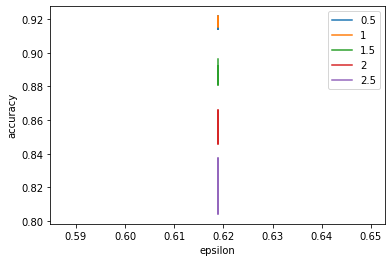

Best accuracy = 0.9217 at epoch 4 
Best epsilon = 0.6188836247099821 at epoch 9


In [25]:
# test clip bounds
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for cb in clip_bounds:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)
    for epoch in range(1,10):
        model = SampleConvNet()
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sample_rate,
            noise_multiplier, cb, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
    plt.plot(x, y, label=cb)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

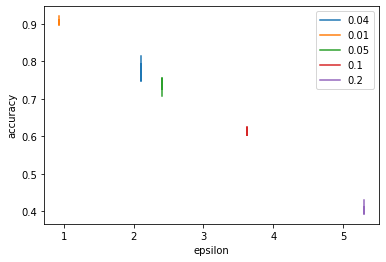

Best accuracy = 0.9206 at epoch 1 
Best epsilon = 0.9368228467889199 at epoch 9


In [26]:
# test sample rates
best_eps = float('inf')
best_eps_ep = 0
best_acc = 0
best_acc_ep = 0
for sr in sample_rates:
    x = []
    y = []
    train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sr)
    for epoch in range(1,10):
        model = SampleConvNet()
        epsilon, alpha = train(
            model, train_loader, torch.optim.SGD, learning_rate, num_epochs, sr,
            noise_multiplier, clip_bound, delta
        )
        x.append(epsilon)
        _, total_accuracy = test(model, test_loader)
        y.append(total_accuracy)
        if epsilon <= best_eps:
            best_eps = epsilon
            best_eps_ep = epoch
        if best_acc <= total_accuracy:
            best_acc = total_accuracy
            best_acc_ep = epoch
    plt.plot(x, y, label=sr)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Best accuracy =', best_acc, 'at epoch', best_acc_ep, '\nBest epsilon =', best_eps, 'at epoch', best_eps_ep)

In [31]:
# final experiment

torch.manual_seed(54356)

train_tensor, test_tensor = get_mnist_dataset()
input_dim = train_tensor[0][0].size(dim=0)
delta = 1e-5

clip_bound = 1.5
learning_rate = 0.1
sample_rate = 0.004
noise_multiplier = 1.3

train_loader, test_loader = create_data_loaders(train_tensor, test_tensor, sample_rate)

for epoch in range(1,11):
    model = SampleConvNet()
    epsilon, alpha = train(
        model, train_loader, torch.optim.SGD, learning_rate, epoch, sample_rate,
        noise_multiplier, clip_bound, delta
    )
    _, total_accuracy = test(model, test_loader)
    print('At epoch', epoch, 'epsilon =', epsilon, 'accuracy =', total_accuracy)

At epoch 1 epsilon = 0.4838172271441112 accuracy = 0.7029
At epoch 2 epsilon = 0.5175838265355789 accuracy = 0.8755
At epoch 3 epsilon = 0.5513504259270466 accuracy = 0.8767
At epoch 4 epsilon = 0.5851170253185144 accuracy = 0.8972
At epoch 5 epsilon = 0.6188836247099821 accuracy = 0.9112
At epoch 6 epsilon = 0.6526502241014499 accuracy = 0.927
At epoch 7 epsilon = 0.6864168234929177 accuracy = 0.9042
At epoch 8 epsilon = 0.7166262161561463 accuracy = 0.9234
At epoch 9 epsilon = 0.7459723199580783 accuracy = 0.9118
At epoch 10 epsilon = 0.7753184237600104 accuracy = 0.9216


## Task 3: Your own problem in privacy-preserving machine learning

State and solve your own problem related to privacy-preserving machine learning.

You can use code available online, as long as you cite the source.

You can for example try reproducing the results of some interesting paper using their data or your own data, try out some of the privacy attacks, or simply try the above examples using more complex models and/or on different data sets.

If your problem is based on some previous problem, it should extend it in a non-trivial manner (not just running exact same code with new parameters or data).

The evaluation of the project will take the difficulty of your chosen problem into account.

This task is worth as much as two regular problems.

### Answer

#### Purpose of the project
For this task I decided to re-implement a classifier for malignant skin cancer, written by Ruchita Suranagi and published at [this link](https://github.com/RuchitaSuranagi/Skin-Cancer-Classifier/blob/main/Malignant_vs_Benign_DP_Opacus_Skin_Cancer_Classification.ipynb). My idea was to try to achieve a better accuracy and/or better privacy guarantees: in fact, Ruchita was able to achieve an overall good accuracy ($0.803$), but with very bad privacy guarantees ($\epsilon = 47.58$ with $\delta = 10^{-5}$), and I wanted mostly to see if I was able to achieve a stronger privacy without loosing (too much) accuracy, and/or if I was able to find a possible error that made the $\epsilon$ so high.

#### Brief overview on the original problem
The problem analyzed in this task is to train a neural network that allows to recognize a skin cancer; to be more precise, the task is to discriminate between malignant and benign skin cancer. The dataset used is [Skin Cancer: Malignant or Benign](https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign); this dataset contains two folders, both containing 1800 pictures `224x244` of the two types of moles (benign and malignant). The dataset is divided into two more folders, one for training and one for testing.
In order to ensure privacy for the "owners of the skin cancer", _i.e._ to prevent unintended memorization, the models are trained using differential privacy with $\delta = 10^{-5}$ with the `opacus` library.

#### Execution
First of all, I copied most part of the code (the useful parts, so without the in-work visualizations) and I refactored it in a way that it would be easy for me to starts from. The most useful (and in-scope) refactor I did was to parametrize the different parts of the code I could modify, in order to modify them faster. Then I modified the way the dataset is loaded, in order to have platform-independent data (the code automatically downloads and unzips the dataset in the right folder).

The first thing I tried was to tweak the usual hyperparameters; I tried different values, that were:

- NOISE_MULTIPLIER, _i.e._ the noise multiplier = [0.2, 0.38, 0.5, 1]
- LR, _i.e._ learning rate = [0.001, 0.005, 0.01, 0.1]
- MAX_GRAD_NORM, _i.e._ the clip bound = [1, 1.2, 1.5, 2]

Unfortunately, none of these changed significatively the $\epsilon$, which continued to be too high.

Then, I noticed that data augmentation was performed on the dataset images: in the transform pipeline, in fact, not only the images was converted into tensors (which is necessary), but random resizing and rotation were performed on them. According to [this opacus tutorial](https://opacus.ai/tutorials/building_image_classifier), introducing data augmentation in image classification tasks with opacus could lead to weird behaviors; I thought that this data augmentation could be the cause of a such high $\epsilon$, and then I tweaked that part, removing the unwanted data augmentation procedures, and restarted training with different values. In the end, I was able to achieve a better $\epsilon$ with more or less the same accuracy on both the train and the test set, as reported at the end of the notebook.

#### Preparatory code (only refactoring performed)

In [ ]:
# installing dependencies
import sys
!{sys.executable} -m pip install torch opacus opencv-python torchcsprng seaborn gdown scikit-learn

In [31]:
# Import libraries

# general libraries
import numpy as np
import pandas as pd
from glob import glob
import os,cv2
from sklearn.model_selection import train_test_split
import gdown
import zipfile
from tqdm import tqdm

# torch-related libraries
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,SubsetRandomSampler
import torch.nn.functional as F

# opacus-related libraries
from opacus import PrivacyEngine
from opacus.utils import module_modification
from opacus.dp_model_inspector import DPModelInspector

# suppress useless warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Seed everything for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
# Download data
url = 'https://drive.google.com/uc?id=1CmSVlSuMghyQlsUkKMn_svSn0BIzxjQv'
output = 'archive.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./t3_data/')

os.remove('./archive.zip')

# Load data
all_image_path = glob(os.path.join('./t3_data/data/train', '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [4]:
# Normalize the image and computes mean and std of the three channels on the whole dataset
def compute_img_mean_std(image_paths):
    img_h, img_w = 224, 224
    imgs = []
    norm_mean, norm_std_dev = [], []

    for i in range(len(image_paths)):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()
        norm_mean.append(np.mean(pixels))
        norm_std_dev.append(np.std(pixels))

    norm_mean.reverse()
    norm_std_dev.reverse()

    return norm_mean,norm_std_dev

norm_mean, norm_std_dev = compute_img_mean_std(all_image_path)

#### Dataset-related code: image transform and dataset creation (image transforms modified)

In [54]:
image_transforms = {
    "train": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
]),
    "test": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
])}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

# Create datasets
train_dataset = datasets.ImageFolder(root = './t3_data/data/train', transform = image_transforms["train"])
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

train_idx = dataset_indices[ 0 : int(np.floor(dataset_size))]
train_sampler = SubsetRandomSampler(train_idx)
test_dataset = datasets.ImageFolder(root = './t3_data/data/test', transform = image_transforms["test"])


#### Train part

In [56]:
# Hyper parameters

MAX_GRAD_NORM = 1.5
NOISE_MULTIPLIER = 0.45
DELTA = 1e-5

LR = 5e-4
NUM_WORKERS = 8

BATCH_SIZE = 32
VIRTUAL_BATCH_SIZE = 64


In [57]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

def accuracy(preds, labels):
    return (preds == labels).mean()

# train and test functions
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []

    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)


        # compute output
        output = model(images)
        loss = criterion(output, target)
        
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()
        
        # measure accuracy and record loss
        acc = accuracy(preds, labels)

        losses.append(loss.item())
        top1_acc.append(acc)
        
        loss.backward()
        	
        # take a real optimizer step after N_VIRTUAL_STEP steps t
        if ((i + 1) % virtual_batch_rate == 0) or ((i + 1) == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        else:
            optimizer.virtual_step() # take a virtual step

        if i % 200 == 0:
            epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {np.mean(losses):.6f} "
                f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                f"(ε = {epsilon:.2f}, δ = {DELTA})"
            )

def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)
    
    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

In [58]:
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler,num_workers=NUM_WORKERS, drop_last = True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

single_batch = next(iter(train_loader))

single_image = single_batch[0][0]

# TRAIN MODEL
model = models.resnet18(num_classes=2)
inspector = DPModelInspector()
model = module_modification.convert_batchnorm_modules(model)
inspector = DPModelInspector()
inspector.validate(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)
privacy_engine = PrivacyEngine(
    model,
    batch_size=VIRTUAL_BATCH_SIZE,
    sample_size=len(train_dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
)
privacy_engine.attach(optimizer)

assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 
virtual_batch_rate = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

for epoch in tqdm(range(10), desc="Epoch", unit="epoch"):
    train(model, train_loader, optimizer, epoch + 1, 'cpu')
    test(model, test_loader, 'cpu')

Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 0.987126 Acc@1: 50.000000 (ε = 0.10, δ = 1e-05)


Epoch:  10%|█         | 1/10 [02:53<26:00, 173.43s/epoch]

	Test set:Loss: 0.737602 Acc: 77.500000 
	Train Epoch: 2 	Loss: 0.553758 Acc@1: 81.250000 (ε = 13.34, δ = 1e-05)


Epoch:  20%|██        | 2/10 [05:47<23:10, 173.81s/epoch]

	Test set:Loss: 1.041298 Acc: 77.589286 
	Train Epoch: 3 	Loss: 0.654026 Acc@1: 87.500000 (ε = 16.17, δ = 1e-05)


Epoch:  30%|███       | 3/10 [08:40<20:12, 173.27s/epoch]

	Test set:Loss: 0.944488 Acc: 79.375000 
	Train Epoch: 4 	Loss: 0.724972 Acc@1: 81.250000 (ε = 18.44, δ = 1e-05)


Epoch:  40%|████      | 4/10 [11:33<17:19, 173.28s/epoch]

	Test set:Loss: 0.784898 Acc: 79.494048 
	Train Epoch: 5 	Loss: 0.945313 Acc@1: 78.125000 (ε = 20.31, δ = 1e-05)


Epoch:  50%|█████     | 5/10 [14:28<14:28, 173.76s/epoch]

	Test set:Loss: 0.834357 Acc: 80.238095 
	Train Epoch: 6 	Loss: 0.460885 Acc@1: 90.625000 (ε = 22.16, δ = 1e-05)


Epoch:  60%|██████    | 6/10 [17:20<11:33, 173.46s/epoch]

	Test set:Loss: 0.814087 Acc: 79.880952 
	Train Epoch: 7 	Loss: 0.721337 Acc@1: 81.250000 (ε = 23.63, δ = 1e-05)


Epoch:  70%|███████   | 7/10 [20:14<08:40, 173.45s/epoch]

	Test set:Loss: 0.837522 Acc: 80.089286 
	Train Epoch: 8 	Loss: 0.499970 Acc@1: 81.250000 (ε = 25.10, δ = 1e-05)


Epoch:  80%|████████  | 8/10 [23:08<05:47, 173.57s/epoch]

	Test set:Loss: 0.855306 Acc: 80.476190 
	Train Epoch: 9 	Loss: 1.100996 Acc@1: 75.000000 (ε = 26.57, δ = 1e-05)


Epoch:  90%|█████████ | 9/10 [26:01<02:53, 173.58s/epoch]

	Test set:Loss: 0.919086 Acc: 80.476190 
	Train Epoch: 10 	Loss: 0.743814 Acc@1: 87.500000 (ε = 28.04, δ = 1e-05)


Epoch: 100%|██████████| 10/10 [28:55<00:00, 173.52s/epoch]

	Test set:Loss: 0.877125 Acc: 80.773810 


Note: the "Test set" output refers to the previous epoch.
From these results is pretty clear that I've been able to improve the privacy of the classification task: removing the data augmentation parts and tweaking the hyperparameters, in fact, allowed me to keep the $\epsilon$ more in control, without too high peaks.
A good compromise for this problem could be the last one I executed. To be more precise, with

- MAX_GRAD_NORM = 1.5
- NOISE_MULTIPLIER = 0.45
- LR = 5e-4
- BATCH_SIZE = 32

I was able to achieve a $(16.17, 10^{-5})$-DP with $0.875$ accuracy on the training set and $0.794$ accuracy on the test set.